In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)
pd.set_option('display.precision', 4)


In [3]:
# Reproducible random data (already saved as CSV for reference)
from pathlib import Path
import numpy as np # Add import statement here

rng = np.random.default_rng(7)

# Load the prepared CSV so students can also download it if needed
df = pd.read_csv('/content/loan_toy_simple.csv')
df.head()

,salary_lakhs,loan_lakhs,approve
0,12.0015,1.2712,1
1,16.3554,12.9408,1
2,14.4110,16.0674,1
3,5.6033,10.7471,0
4,6.8027,14.7911,0


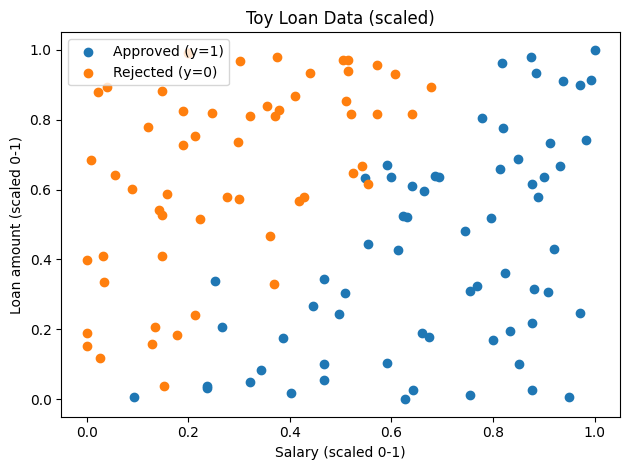

In [4]:
def minmax(a: np.ndarray):
    return (a - a.min()) / (a.max() - a.min())

salary = minmax(df['salary_lakhs'].values)
loan   = minmax(df['loan_lakhs'].values)
y      = df['approve'].values.astype(float)

X = np.column_stack([salary, loan])  # shape (n, 2)

# Quick scatter
plt.figure()
plt.scatter(X[y==1,0], X[y==1,1], label='Approved (y=1)')
plt.scatter(X[y==0,0], X[y==0,1], label='Rejected (y=0)')
plt.xlabel('Salary (scaled 0-1)')
plt.ylabel('Loan amount (scaled 0-1)')
plt.legend()
plt.title('Toy Loan Data (scaled)')
plt.tight_layout()
plt.show()


In [5]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def predict_proba(W, b, X):
    return sigmoid(X @ W + b)

def log_loss(p, y):
    eps = 1e-12
    p = np.clip(p, eps, 1-eps)
    return -np.mean(y*np.log(p) + (1-y)*np.log(1-p))

def gradients(W, b, X, y):
    p = predict_proba(W, b, X)
    diff = (p - y)        # shape (n,)
    dW = (X.T @ diff) / X.shape[0]
    db = np.mean(diff)
    return dW, db, p


In [6]:
rng = np.random.default_rng(0)
W = rng.normal(0, 0.01, size=2)
b = 0.0
lr = 0.5
epochs = 80

print('Initial W:', W)
print('Initial b:', b)


Initial W: [ 0.0013 -0.0013]
Initial b: 0.0


In [7]:
# Compute current loss and one GD step
dW, db, p = gradients(W, b, X, y)
before = log_loss(p, y)

W = W - lr * dW
b = b - lr * db

dW2, db2, p2 = gradients(W, b, X, y)
after = log_loss(p2, y)

print('dW (first step):', dW)
print('db (first step):', db)
print('loss before:', round(before, 4), ' -> loss after:', round(after, 4))
print('W after one step:', W, '  b:', round(b, 4))


dW (first step): [-0.1178  0.0401]
db (first step): -0.03334904120065655
loss before: 0.6929  -> loss after: 0.6848
W after one step: [ 0.0602 -0.0214]   b: 0.0167


In [8]:
hist = []
for ep in range(epochs):
    dW, db, p = gradients(W, b, X, y)
    loss = log_loss(p, y)
    hist.append((ep, W.copy(), b, loss))
    W -= lr * dW
    b -= lr * db
    if ep % 10 == 0 or ep == epochs-1:
        print(f'epoch {ep:3d} | loss={loss:.4f} | W={W} | b={b:.4f}')

# Save history as a small DataFrame
hist_df = pd.DataFrame({
    "epoch": [h[0] for h in hist],
    "w1": [h[1][0] for h in hist],
    "w2": [h[1][1] for h in hist],
    "b":  [h[2] for h in hist],
    "loss": [h[3] for h in hist],
})
hist_df.tail()


epoch   0 | loss=0.6848 | W=[ 0.1162 -0.0436] | b=0.0289
epoch  10 | loss=0.6230 | W=[ 0.5913 -0.3129] | b=0.0360
epoch  20 | loss=0.5742 | W=[ 0.9962 -0.5846] | b=-0.0124
epoch  30 | loss=0.5338 | W=[ 1.3636 -0.8332] | b=-0.0635
epoch  40 | loss=0.4999 | W=[ 1.701  -1.0591] | b=-0.1117
epoch  50 | loss=0.4712 | W=[ 2.0126 -1.2655] | b=-0.1567
epoch  60 | loss=0.4466 | W=[ 2.3016 -1.4551] | b=-0.1988
epoch  70 | loss=0.4254 | W=[ 2.5709 -1.6304] | b=-0.2382
epoch  79 | loss=0.4087 | W=[ 2.7984 -1.7776] | b=-0.2716


,epoch,w1,w2,b,loss
75,75,2.6736,-1.6970,-0.2532,0.4159
76,76,2.6989,-1.7134,-0.2570,0.4141
77,77,2.7240,-1.7296,-0.2606,0.4123
78,78,2.7490,-1.7457,-0.2643,0.4105
79,79,2.7737,-1.7617,-0.2679,0.4087


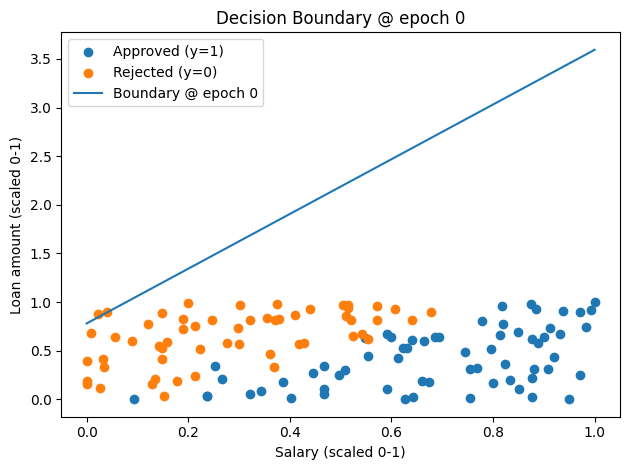

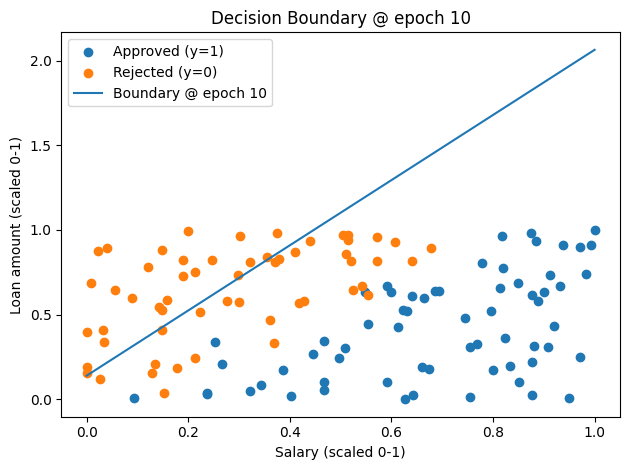

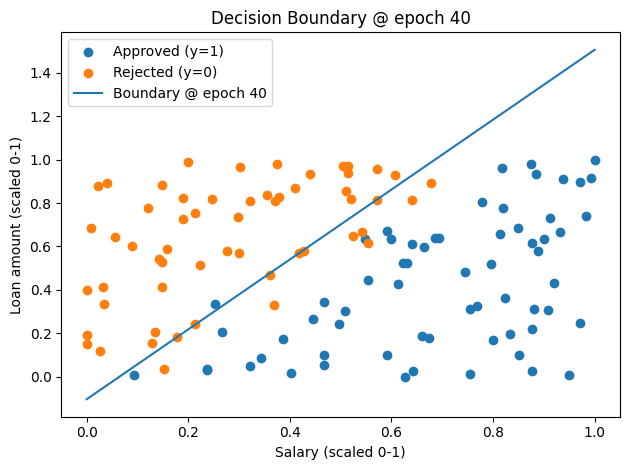

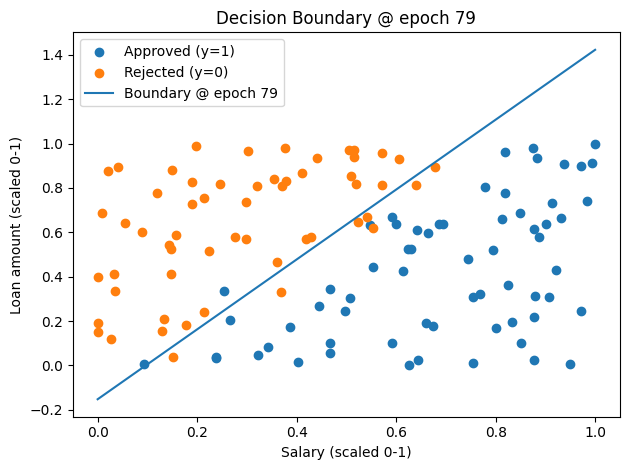

In [9]:
def boundary_points(w, b, x1_min=0.0, x1_max=1.0, num=200):
    x1 = np.linspace(x1_min, x1_max, num=num)
    if abs(w[1]) < 1e-12:
        x1_line = np.full_like(x1, -b/(w[0] if abs(w[0])>1e-12 else 1e-12))
        x2_line = np.linspace(0.0, 1.0, num=num)
        return x1_line, x2_line
    x2 = -(w[0]/w[1])*x1 - b/w[1]
    return x1, x2

# Show boundary at a few epochs (0, 10, 40, last)
snapshots = [0, 10, 40, hist_df['epoch'].iloc[-1]]
for ep in snapshots:
    row = hist_df.loc[hist_df['epoch']==ep].iloc[0]
    w = np.array([row['w1'], row['w2']])
    b_ep = row['b']
    x1_line, x2_line = boundary_points(w, b_ep)
    plt.figure()
    plt.scatter(X[y==1,0], X[y==1,1], label='Approved (y=1)')
    plt.scatter(X[y==0,0], X[y==0,1], label='Rejected (y=0)')
    plt.plot(x1_line, x2_line, label=f'Boundary @ epoch {ep}')
    plt.xlabel('Salary (scaled 0-1)')
    plt.ylabel('Loan amount (scaled 0-1)')
    plt.title(f'Decision Boundary @ epoch {ep}')
    plt.legend()
    plt.tight_layout()
    plt.show()


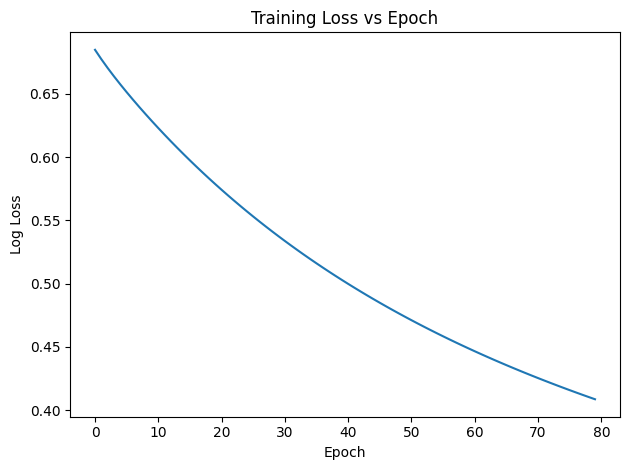

In [10]:
plt.figure()
plt.plot(hist_df['epoch'].values, hist_df['loss'].values)
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Training Loss vs Epoch')
plt.tight_layout()
plt.show()


# Task
Modify the provided code to adjust the learning rate and epochs, add L2 regularization, and change the prediction threshold to 0.4. Analyze the impact of these changes on the model's performance and decision boundary.

## Adjust learning rate and epochs

### Subtask:
Modify the cell containing the learning rate (`lr`) and number of epochs (`epochs`) to the desired values.


**Reasoning**:
The subtask requires modifying the learning rate and the number of epochs. This can be done by directly changing the values of the `lr` and `epochs` variables in the code block where they are defined.



In [11]:
rng = np.random.default_rng(0)
W = rng.normal(0, 0.01, size=2)
b = 0.0
lr = 1.0
epochs = 200

print('Initial W:', W)
print('Initial b:', b)

Initial W: [ 0.0013 -0.0013]
Initial b: 0.0


## Add l2 regularization

### Subtask:
Modify the gradient descent update rule in the training loop to include L2 regularization.


**Reasoning**:
Modify the training loop to include L2 regularization by adding the regularization gradient to dW.



In [12]:
reg_strength = 0.01  # Define regularization strength

hist = []
for ep in range(epochs):
    dW, db, p = gradients(W, b, X, y)
    loss = log_loss(p, y)
    hist.append((ep, W.copy(), b, loss))

    # Add L2 regularization to the weight gradient
    dW += reg_strength * W

    W -= lr * dW
    b -= lr * db
    if ep % 10 == 0 or ep == epochs-1:
        print(f'epoch {ep:3d} | loss={loss:.4f} | W={W} | b={b:.4f}')

# Save history as a small DataFrame
hist_df = pd.DataFrame({
    "epoch": [h[0] for h in hist],
    "w1": [h[1][0] for h in hist],
    "w2": [h[1][1] for h in hist],
    "b":  [h[2] for h in hist],
    "loss": [h[3] for h in hist],
})
hist_df.tail()

epoch   0 | loss=0.6929 | W=[ 0.119  -0.0414] | b=0.0333
epoch  10 | loss=0.5826 | W=[ 0.9532 -0.5588] | b=-0.0077
epoch  20 | loss=0.5158 | W=[ 1.5574 -0.9645] | b=-0.0971
epoch  30 | loss=0.4715 | W=[ 2.0221 -1.2654] | b=-0.1706
epoch  40 | loss=0.4408 | W=[ 2.3845 -1.4925] | b=-0.2313
epoch  50 | loss=0.4187 | W=[ 2.6705 -1.6666] | b=-0.2817
epoch  60 | loss=0.4024 | W=[ 2.8983 -1.8015] | b=-0.3237
epoch  70 | loss=0.3902 | W=[ 3.0809 -1.9071] | b=-0.3587
epoch  80 | loss=0.3807 | W=[ 3.2281 -1.9903] | b=-0.3881
epoch  90 | loss=0.3734 | W=[ 3.3474 -2.0561] | b=-0.4128
epoch 100 | loss=0.3676 | W=[ 3.4443 -2.1085] | b=-0.4335
epoch 110 | loss=0.3630 | W=[ 3.5233 -2.1504] | b=-0.4509
epoch 120 | loss=0.3594 | W=[ 3.5878 -2.1838] | b=-0.4655
epoch 130 | loss=0.3565 | W=[ 3.6406 -2.2106] | b=-0.4778
epoch 140 | loss=0.3541 | W=[ 3.6839 -2.2322] | b=-0.4881
epoch 150 | loss=0.3522 | W=[ 3.7194 -2.2495] | b=-0.4968
epoch 160 | loss=0.3507 | W=[ 3.7486 -2.2635] | b=-0.5041
epoch 170 | los

,epoch,w1,w2,b,loss
195,195,3.8142,-2.2936,-0.5213,0.3472
196,196,3.8155,-2.2942,-0.5216,0.3471
197,197,3.8169,-2.2947,-0.5220,0.3471
198,198,3.8182,-2.2953,-0.5224,0.3470
199,199,3.8194,-2.2959,-0.5227,0.3469


## Change threshold

### Subtask:
Modify the code to calculate predictions using a threshold of 0.4 instead of the default 0.5.


**Reasoning**:
The subtask is to define a new function `predict` that uses a specified threshold to make binary predictions from the probabilities calculated by `predict_proba`.



In [13]:
def predict(W, b, X, threshold=0.5):
    """
    Predicts binary outcomes based on logistic regression probabilities and a threshold.

    Args:
        W (np.ndarray): Weight vector.
        b (float): Bias term.
        X (np.ndarray): Input features.
        threshold (float): The probability threshold for classification.

    Returns:
        np.ndarray: Binary predictions (0 or 1).
    """
    probabilities = predict_proba(W, b, X)
    return (probabilities >= threshold).astype(int)


## Analyze results with new threshold

### Subtask:
Visualize the decision boundary and evaluate the model performance using the new threshold.


**Reasoning**:
Visualize the decision boundary and evaluate the model performance using the new threshold of 0.4.



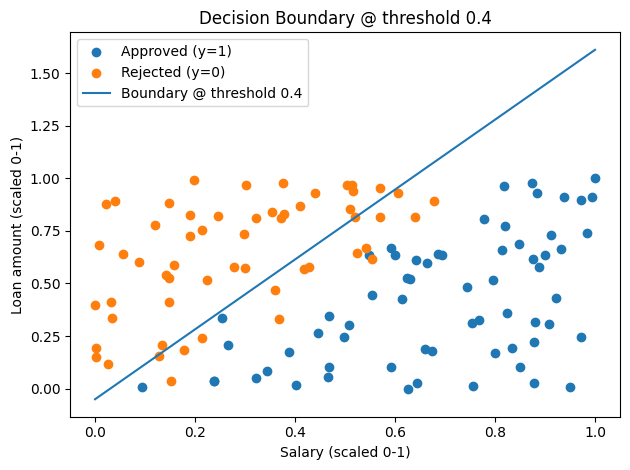

Accuracy with threshold 0.4: 0.8750


In [14]:
# 1. Get the final trained weights and bias from hist_df.
final_row = hist_df.iloc[-1]
final_w = np.array([final_row['w1'], final_row['w2']])
final_b = final_row['b']
new_threshold = 0.4

# 2. Use the boundary_points function to calculate the coordinates for the decision boundary.
# The decision boundary is where predict_proba(W, b, X) = threshold
# sigmoid(X @ W + b) = threshold
# X @ W + b = log(threshold / (1 - threshold))
# X @ W = log(threshold / (1 - threshold)) - b
# w1*x1 + w2*x2 = log(threshold / (1 - threshold)) - b
# x2 = (-w1/w2)*x1 + (log(threshold / (1 - threshold)) - b)/w2

log_odds_threshold = np.log(new_threshold / (1 - new_threshold))
effective_b = final_b - log_odds_threshold

x1_line, x2_line = boundary_points(final_w, effective_b)

# 3. Plot the scaled data points (approved and rejected).
plt.figure()
plt.scatter(X[y==1,0], X[y==1,1], label='Approved (y=1)')
plt.scatter(X[y==0,0], X[y==0,1], label='Rejected (y=0)')

# 4. Plot the calculated decision boundary line.
plt.plot(x1_line, x2_line, label=f'Boundary @ threshold {new_threshold}')

# 5. Add labels and a title to the plot.
plt.xlabel('Salary (scaled 0-1)')
plt.ylabel('Loan amount (scaled 0-1)')
plt.title(f'Decision Boundary @ threshold {new_threshold}')
plt.legend()
plt.tight_layout()

# 6. Display the plot.
plt.show()

# 7. Calculate predictions for the entire dataset X using the predict function.
predictions = predict(final_w, final_b, X, threshold=new_threshold)

# 8. Calculate the accuracy of these predictions.
accuracy = np.mean(predictions == y)

# 9. Print the calculated accuracy.
print(f'Accuracy with threshold {new_threshold}: {accuracy:.4f}')

## Summary:

### Data Analysis Key Findings

*   The final accuracy with a prediction threshold of 0.4 is 0.8750.
*   The decision boundary visualized for the 0.4 threshold shows how the model separates the data points based on this lower probability threshold.
*   L2 regularization was successfully incorporated into the model training, which is expected to help prevent overfitting.
*   The learning rate was adjusted to 1.0 and the number of epochs to 200 for training.

### Insights or Next Steps

*   Compare the performance (e.g., accuracy, precision, recall) with the 0.4 threshold against the default 0.5 threshold to understand the impact of this change.
*   Experiment with different regularization strengths and learning rates to further optimize model performance and decision boundary.
